In [1]:
import matplotlib.pyplot as plt
from JuRunPlatform import StrategyPlatform
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm

sp1=StrategyPlatform(useSubUniverse=True,subUnivName='HS300')
sp1.SetDate(20170101,20181031)


Data Loaded...
Data Loaded...


In [2]:
def helper1(df):
    df=(df-df.iloc[0,:])/df.iloc[0,:]
    return df

In [3]:
Size=sp1.LoadDF('mkt_cap_ashare2')
TurnOver=sp1.LoadDF('turn')
ATOT=sp1.LoadDF('rating_instnum')
Close=sp1.LoadDF('close_N')
temper=sp1.LoadDF('close_N')
# Returns=(Close-Close.iloc[0,:])/Close.iloc[0,:]
Close.index=pd.to_datetime(Close.index, format='%Y%m%d.0')
Returns=Close.groupby(pd.Grouper(freq='AS')).apply(helper1)
rreturns=(Close-Close.shift(1))/Close.shift(1)


In [4]:
Size=Size.fillna(method="ffill")
TurnOver=TurnOver.fillna(method="ffill")
ATOT=ATOT.fillna(method="ffill")
Returns=Returns.fillna(method="ffill")

In [5]:
def rank(array):
    s=pd.Series(array)
    return s.rank(ascending=True)[len(s)-1]

In [6]:
def zscorer(row):
    aver=row.mean()
    stdv=row.std(ddof=0)
    return (row-aver)/stdv

In [7]:
Size=np.log(Size)
ATOT=ATOT.fillna(0)

In [8]:
# Size=Size.apply(lambda row:zscorer(row),axis=1)
# TurnOver=TurnOver.apply(lambda row:zscorer(row),axis=1)
# ATOT=ATOT.apply(lambda row:zscorer(row),axis=1)
# Returns=Returns.apply(lambda row:zscorer(row),axis=1)


In [9]:
Size.index=pd.to_datetime(Size.index, format='%Y%m%d.0')
TurnOver.index=pd.to_datetime(TurnOver.index, format='%Y%m%d.0')
ATOT.index=pd.to_datetime(ATOT.index, format='%Y%m%d.0')
Returns.index=pd.to_datetime(Returns.index, format='%Y%m%d.0')
SizeM=Size.groupby(pd.Grouper(freq="M")).mean()
TurnOverM=TurnOver.groupby(pd.Grouper(freq="M")).mean()
ATOTM=ATOT.groupby(pd.Grouper(freq="M")).sum()
ReturnsM=Returns.groupby(pd.Grouper(freq="M")).mean()


In [10]:
es=[]
for i in range(len(ATOTM.iloc[0,:])):
    y=np.array(ATOTM.iloc[:,i])
    x1=np.array([SizeM.iloc[:,i]])
    x2=np.array([TurnOverM.iloc[:,i]])
    x3=np.array([ReturnsM.iloc[:,i]])
    x=np.array(np.concatenate((x1,x2,x3),axis=0))
    x=x.T
    X=sm.add_constant(x)
    results=sm.OLS(y,X).fit()
    es.append(results.resid)
#     y=np.array(ATOTM.iloc[:,i])
#     x1=np.array([SizeM.iloc[:,i]])
#     x2=np.array([TurnOverM.iloc[:,i]])
#     x3=np.array([ReturnsM.iloc[:,i]])
    
#     x=np.array(np.concatenate((x1,x2,x3),axis=0))
    
#     a,b,c,d=np.linalg.pinv((x.T).dot(x)).dot(x.T.dot(y))
#     aas.append(a)
#     bs.append(b)
#     cs.append(c)
#     ds.append(d)


In [11]:
es

[array([ -25.90902863,   -8.66621425,   86.26338552,  -27.76429749,
           4.79341872,   45.57880315,  -37.94825667,   90.74611251,
          49.44506607,  -82.90965496,  -24.92990177,  -45.80231664,
         120.01892578,  -89.68566991,   40.7076874 ,  -13.39592294,
          42.7789707 , -123.32110659]),
 array([ -91.4033926 ,  -55.44609991,   23.24042611,    3.69305071,
          38.26579186,   39.34025631,  -14.4088823 ,   75.1633842 ,
          27.60584216,  -99.51716707,   30.87406136,   18.05017978,
          36.89134162, -119.08654714,   72.19484374,   -1.10845843,
         149.82473814, -134.17336852]),
 array([-2.31162393, -2.05227294,  2.96770269, -2.20130662,  0.32159262,
         1.92512516, -0.63802217,  2.05502089, -0.95277328, -2.93765434,
         2.39895547,  1.52578618,  3.21196882, -3.61746308,  3.23746752,
        -0.58303232,  3.6750193 , -6.02448996]),
 array([ -8.4541657 ,  -9.25735345,  -5.47478496,   7.46541113,
         -5.90835191,  -6.51201615,  -9.8954

In [12]:
alpha0=sp1.LoadZeroAlpha()
alphadf=pd.DataFrame(alpha0)
alphadf.index=temper.index
alphadf.columns=Size.columns

for i in range(alphadf.shape[1]):
    m=0
    temp=alphadf.index[0]//100
    for j in range(0,alphadf.shape[0]):
        if temp!=alphadf.index[j]//100:
            m+=1
            temp=alphadf.index[j]//100
        
        alphadf.iloc[j,i]=es[i][m]




                        Sharpe       Return  MaxDrawdown     Turnover
20170104-20171229        1.762        17.84        -6.08          1.2
20180102-20180619       -0.396        -6.84       -10.12          0.8

20170104-20180619        0.787        10.10       -10.12          1.1
Data Loaded...


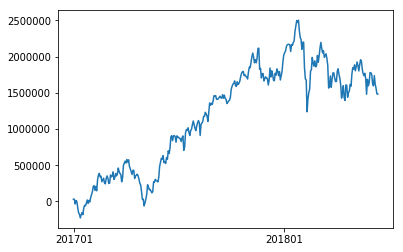

In [13]:
alphat=np.array(alphadf)
#sp1.GeneratePerformance(alphat)
sp1.GeneratePerformance(np.array(ATOT))
# spIdx=StrategyPlatform(stocklistfilename='StockCodesIdx')
# spIdx.SetDate(20170101,20181031)
# hsclose=spIdx.LoadDF('close_N')
# plt.show()
# plt.plot(hsclose['000300.SH'])
aa=sp1.LoadSubUnivPerc()


In [14]:
# #daily
# def factortestd(alpha,Returns):
#     #Returns to get date and column
#     alpha=np.array(alpha)
#     alpha=pd.DataFrame(alpha)
#     #alpha.index=Returns.index
#     #alpha.columns=Returns.columns
#     #index0=[]
#     ret=sp1.LoadZeroAlpha()
#     for i in range(alpha.shape[0]):
#         index0=alpha.iloc[i,:].sort_values(ascending=False).iloc[0:int(alpha.shape[1]/5)].index
#         #print(index0)
#         for ind in index0:
#             ret[i,ind]=1
#     sp1.GeneratePerformance(ret)
#     return ret

# factortestd(ATOT,Returns)
        
        
            
            
    


                        Sharpe       Return  MaxDrawdown     Turnover
20170104-20171229        2.516        29.99        -5.52          6.0
20180102-20180619        0.187         3.40        -9.00          5.3

20170104-20180619        1.524        21.65        -9.00          5.8

                        Sharpe       Return  MaxDrawdown     Turnover
20170104-20171229        1.386        14.48        -7.82         12.8
20180102-20180619       -0.781       -14.34       -10.88         10.5

20170104-20180619        0.404         5.44       -10.88         12.1

                        Sharpe       Return  MaxDrawdown     Turnover
20170104-20171229        0.174         1.75        -8.69         13.2
20180102-20180619       -1.086       -18.52       -15.24         11.0

20170104-20180619       -0.363        -4.61       -15.24         12.5

                        Sharpe       Return  MaxDrawdown     Turnover
20170104-20171229       -0.366        -4.45       -14.03         12.0
20180102-2018

[array([[ 1.,  1.,  0., ...,  0.,  0.,  0.],
        [ 1.,  1.,  0., ...,  0.,  0.,  0.],
        [ 1.,  1.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  1.,  0., ...,  0.,  0.,  0.],
        [ 0.,  1.,  0., ...,  0.,  0.,  0.],
        [ 0.,  1.,  0., ...,  0.,  0.,  0.]]),
 array([[ 0.,  0.,  0., ...,  0.,  1.,  0.],
        [ 0.,  0.,  0., ...,  0.,  1.,  0.],
        [ 0.,  0.,  0., ...,  0.,  1.,  0.],
        ..., 
        [ 1.,  0.,  0., ...,  0.,  0.,  1.],
        [ 1.,  0.,  0., ...,  0.,  0.,  1.],
        [ 1.,  0.,  0., ...,  0.,  0.,  1.]]),
 array([[ 0.,  0.,  0., ...,  0.,  0.,  1.],
        [ 0.,  0.,  0., ...,  0.,  0.,  1.],
        [ 0.,  0.,  0., ...,  0.,  0.,  1.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  1.,  0.],
        [ 0.,  0.,  0., ...,  0.,  1.,  0.],
        [ 0.,  0.,  0., ...,  0.,  1.,  0.]]),
 array([[ 0.,  0.,  0., ...,  1.,  0.,  0.],
        [ 0.,  0.,  0., ...,  1.,  0.,  0.],
        [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       

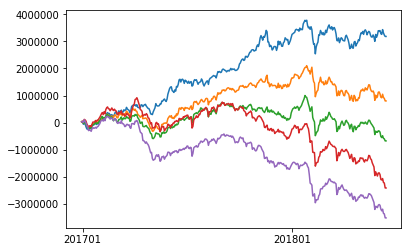

In [15]:
def factortestdd(alpha,Returns):
    #Returns to get date and column
    alpha=np.array(alpha)
    alpha=pd.DataFrame(alpha)
    #alpha.index=Returns.index
    #alpha.columns=Returns.columns
    #index0=[]
    ret=[sp1.LoadZeroAlpha() for i in range(5)]
    for m in range(5):
        for i in range(alpha.shape[0]):
            index0=alpha.iloc[i,:].sort_values(ascending=False).iloc[m*int(alpha.shape[1]/5):(m+1)*int(alpha.shape[1]/5)].index
            #print(index0)
            for ind in index0:
                ret[m][i,ind]=1
        sp1.GeneratePerformance(ret[m])
    return ret

factortestdd(ATOT,Returns)



12.4199424233
3.4200444222
-3.94442488002
-13.8245801405
-22.7496829379


[12.419942423288617,
 3.4200444221961073,
 -3.9444248800224657,
 -13.824580140499226,
 -22.749682937850135]

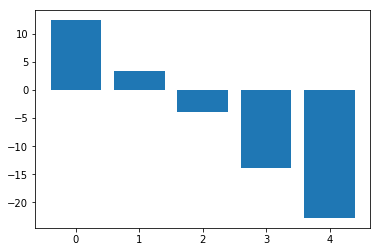

In [16]:
def factorreg(alpha,Returns):
    alpha=np.array(alpha)
    alpha=pd.DataFrame(alpha)
    
    Returns=np.array(Returns)
    ret=[]
    for m in range(5):
        temp=[]
        for i in range(alpha.shape[0]-1):
            index0=alpha.iloc[i,:].sort_values(ascending=False).iloc[m*int(alpha.shape[1]/5):(m+1)*int(alpha.shape[1]/5)].index
            
#             temp2=[]
            for ii in range(len(index0)):
                temp.append(Returns[i+1][index0[ii]])
        
            
        print(np.sum(temp))
        ret.append(sum(temp))   
        
    plotindex=list(range(len(ret)))

    plt.bar(plotindex,ret)       
    return ret
rreturns=rreturns.fillna(method="ffill")
factorreg(ATOT,rreturns)


-5.18754569228
-5.33489358372
-7.5086646562
-7.31450109556
0.666903914874


[-5.1875456922755045,
 -5.3348935837186104,
 -7.5086646562038704,
 -7.3145010955636005,
 0.66690391487442502]

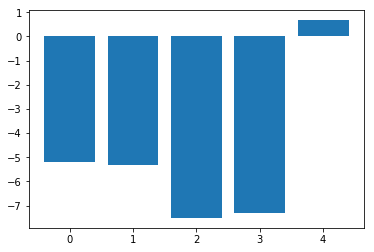

In [17]:
factorreg(alphat,rreturns)

In [18]:
volumes=sp1.LoadDF('volume').fillna(method='ffill')
vwap1=sp1.LoadDF('vwap').fillna(method='ffill')
open1=sp1.LoadDF('open').fillna(method='ffill')
high1=sp1.LoadDF('high').fillna(method='ffill')
low1=sp1.LoadDF('low').fillna(method='ffill')
rankopen=open1.rank(1,ascending=True,method='first')
rankvolume=volumes.rank(1,ascending=True,method='first')
close1=sp1.LoadDF('close').fillna(method='ffill')

-8.91238550306
-10.3030837037
-0.413621371867
-4.77603930233
-0.273571231915


[-8.9123855030626604,
 -10.303083703715551,
 -0.41362137186676673,
 -4.7760393023274723,
 -0.27357123191475619]

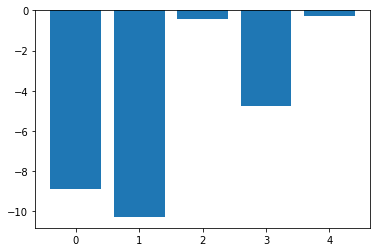

In [19]:
cor1=pd.rolling_corr(rankopen,rankvolume,10)
a1=-1*cor1
factorreg(np.array(a1),rreturns)

-5.48277313863
-10.129017847
-12.3060877454
-0.786509202657
4.02568682072


[-5.4827731386250322,
 -10.129017846956712,
 -12.306087745373029,
 -0.78650920265699342,
 4.0256868207245988]

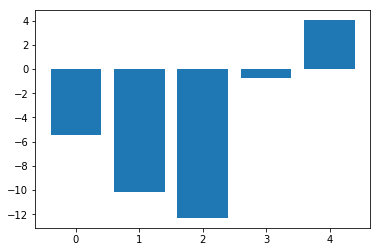

In [20]:
a7=-1*(((open1**5)*(low1-close1)/((low1-high1)*close1)))
factorreg(np.array(a7),rreturns)

-9.42821684212
-8.40080457284
-7.30567706882
0.599421184407
-0.143423813519


[-9.4282168421169636,
 -8.4008045728353498,
 -7.3056770688219581,
 0.59942118440658199,
 -0.14342381351946587]

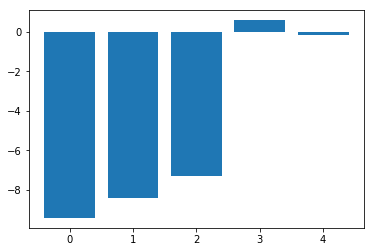

In [21]:
temp8=-1*(((close1-low1)-(high1-close1))/(close1-low1))
a8=-1*(temp8-temp8.shift(9))
factorreg(np.array(a8),rreturns)

-13.9227622841
-5.61840665965
-2.32227500347
-1.56975742861
-1.2454997371


[-13.922762284070203,
 -5.6184066596472242,
 -2.3222750034661548,
 -1.5697574286066442,
 -1.2454997370969156]

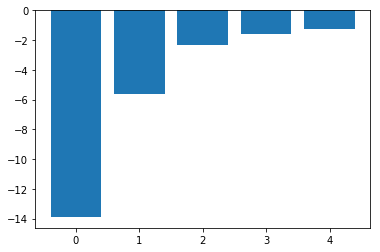

In [22]:
a9=-1*pd.rolling_corr(high1,rankvolume,5)
factorreg(np.array(a9),rreturns)

-8.21535165037
-12.0261523099
-6.95139385446
-5.83427537041
8.34847207225


[-8.215351650373357,
 -12.026152309902377,
 -6.9513938544565237,
 -5.8342753704088333,
 8.3484720722539567]

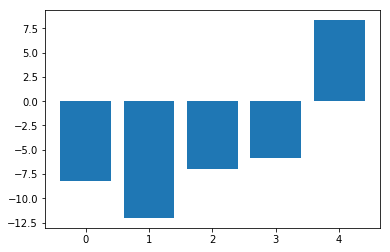

In [23]:
a10=(high1*low1)**0.5-vwap1
factorreg(np.array(a10),rreturns)

-28.6223701125
-2.45229113116
4.65496139747
-1.16254491034
2.9035436436


[-28.622370112458405,
 -2.4522911311554294,
 4.6549613974683828,
 -1.1625449103445193,
 2.9035436436027577]

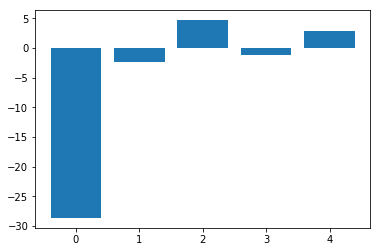

In [24]:
ranklow=low1.rank(1,ascending=True,method='first')
def rank(array):
    s=pd.Series(array)
    return s.rank(ascending=True)[len(s)-1]
a2=-1*pd.rolling_apply(ranklow,9,rank)
factorreg(np.array(a2),rreturns)

-7.49546783399
-5.93100917087
-1.56020859146
-2.64462186186
-7.04739365471


[-7.4954678339910279,
 -5.9310091708659174,
 -1.5602085914599391,
 -2.6446218618611605,
 -7.0473936547090901]

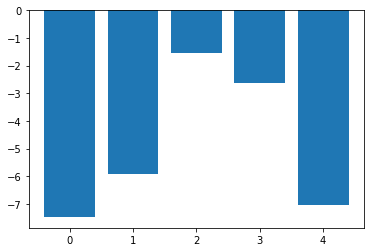

In [25]:
cor2=pd.rolling_corr(open1,volumes,10)
a3=-1*cor2
factorreg(np.array(a3),rreturns)

-1.72614845824
-4.54486540662
-7.58824738098
-9.79569738673
-1.02374248032


[-1.7261484582370259,
 -4.5448654066166476,
 -7.5882473809798672,
 -9.7956973867289499,
 -1.0237424803246424]

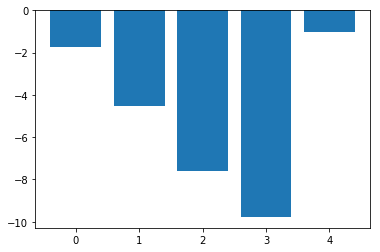

In [26]:
rankvwap=vwap1.rank(1,ascending=True,method='first')
cor3=pd.rolling_corr(rankvolume,rankvwap,6)
sum1=pd.rolling_sum(cor3,2)
temp=sum1/2.0
temp=temp.applymap(lambda x: -1 if x>0.5 else 1 )
a33=temp
factorreg(np.array(a33),rreturns)

0.288719078132
-9.75751982694
-5.5147511621
-4.26096704907
-5.43418215291


[0.28871907813200309,
 -9.7575198269383581,
 -5.5147511621046581,
 -4.2609670490654237,
 -5.4341821529107266]

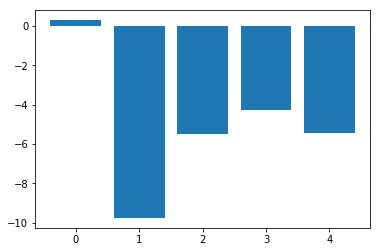

In [27]:
cor4=pd.rolling_corr(rankvolume,rankvwap,5)
rank1=cor4.rank(1,ascending=True,method='first')
max1=pd.rolling_max(rank1,5)
a4=-1*max1
factorreg(np.array(a4),rreturns)

-9.32410452243
-4.22169061545
-3.44273554022
-7.01745017821
-0.672720256584


[-9.3241045224259125,
 -4.2216906154464802,
 -3.4427355402162556,
 -7.0174501782141574,
 -0.67272025658432466]

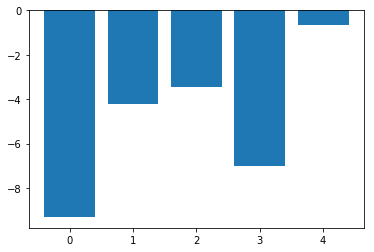

In [28]:
rankclose=close1.rank(1,ascending=True,method='first')
cor5=pd.rolling_corr(rankclose,rankvolume,5)
a5=-1*cor5.rank(1,ascending=True,method='first')
factorreg(np.array(a5),rreturns)

-4.54816598555
-10.3078636552
-7.07302401787
0.147198339946
-2.89684579417


[-4.548165985550253,
 -10.307863655240475,
 -7.0730240178733066,
 0.14719833994597753,
 -2.8968457941690846]

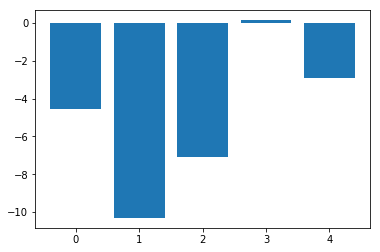

In [29]:
a6=((close1-open1)/((high1-low1)+0.001))#101
factorreg(np.array(a6),rreturns)

7.66821434792
3.96980869012
-3.00119823821
-10.7260330187
-22.5894928941


[7.6682143479161091,
 3.9698086901223264,
 -3.001198238206817,
 -10.726033018668657,
 -22.589492894050082]

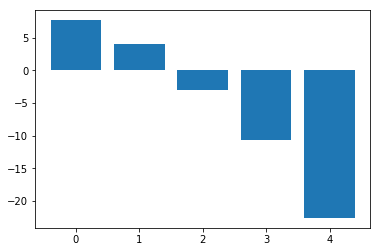

In [30]:
sales=sp1.LoadDF('west_sales_FY2')
sales=sales.fillna(0)
factorreg(np.array(sales),rreturns)

10.6863561474
2.37808496689
-6.9371430874
-11.8013056375
-19.0046935023


[10.686356147410503,
 2.378084966888403,
 -6.9371430874011457,
 -11.801305637496764,
 -19.004693502287996]

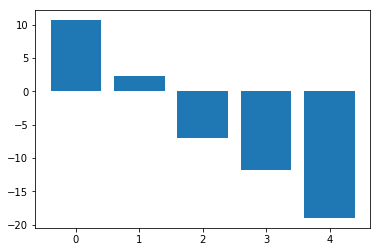

In [31]:
netprofit1=sp1.LoadDF('west_netprofit_FY1').fillna(0)
factorreg(np.array(netprofit1),rreturns)


11.6908435277
2.81744325648
-4.69090592946
-11.9723859609
-22.5236960067


[11.690843527725381,
 2.817443256478311,
 -4.6909059294590918,
 -11.972385960891351,
 -22.523696006740138]

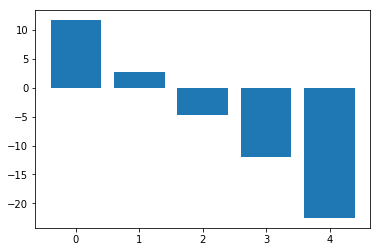

In [32]:
netprofit2=sp1.LoadDF('west_netprofit_FY2').fillna(0)
factorreg(np.array(netprofit2),rreturns)

7.88144042006
3.5548648272
-2.01049327102
-12.0708248663
-22.0336882228


[7.8814404200550436,
 3.5548648271971159,
 -2.0104932710168093,
 -12.070824866347657,
 -22.033688222774803]

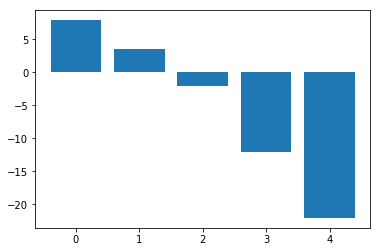

In [33]:
salesM=sp1.LoadDF('west_sales_FTM').fillna(0)
factorreg(np.array(salesM),rreturns)

8.69040891943
-5.09449659501
-11.4407961107
-3.00385457994
-13.8299627467


[8.6904089194290517,
 -5.0944965950134486,
 -11.440796110652094,
 -3.0038545799392571,
 -13.829962746711441]

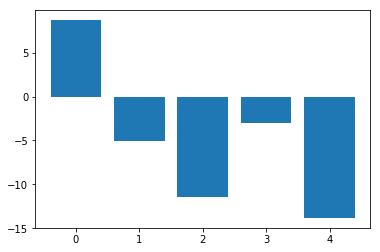

In [34]:
targetprice=sp1.LoadDF('targetprice_avg_wp180').fillna(0)
factorreg(np.array(targetprice),rreturns)

-7.54946543578
2.75853955733
-5.00565320999
-6.95463154019
-7.92749048426


[-7.5494654357781137,
 2.7585395573285223,
 -5.005653209986848,
 -6.9546315401896051,
 -7.9274904842610585]

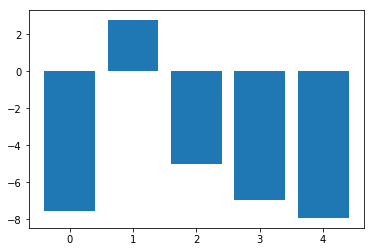

In [35]:
mfd_sellamt_d_4=sp1.LoadDF('mfd_sellamt_d_4').fillna(0)
factorreg(np.array(mfd_sellamt_d_4),rreturns)

-5.11728415948
2.15273499342
-7.67000568864
-7.32642970864
-6.71771654954


[-5.1172841594825362,
 2.1527349934220381,
 -7.6700056886436716,
 -7.3264297086414096,
 -6.7177165495415085]

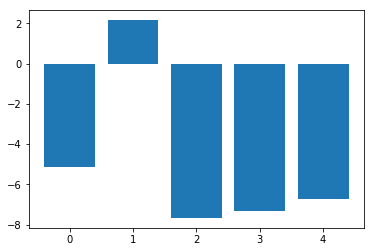

In [36]:
mfd_sellamt_d_3=sp1.LoadDF('mfd_sellamt_d_3').fillna(0)
factorreg(np.array(mfd_sellamt_d_3),rreturns)

-4.82627289494
0.0645822773937
-6.49468063461
-6.28506490362
-7.13726495711


[-4.8262728949378184,
 0.064582277393705631,
 -6.4946806346073327,
 -6.2850649036210537,
 -7.1372649571146001]

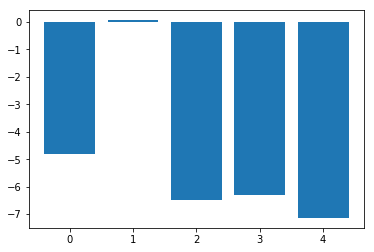

In [37]:
mfd_sellamt_d_2=sp1.LoadDF('mfd_sellamt_d_2').fillna(0)
factorreg(np.array(mfd_sellamt_d_2),rreturns)

-0.0990547659337
-2.31612453138
-3.52578258015
-7.87014312319
-10.8675961122


[-0.099054765933717828,
 -2.3161245313795802,
 -3.525782580150266,
 -7.8701431231887797,
 -10.867596112234807]

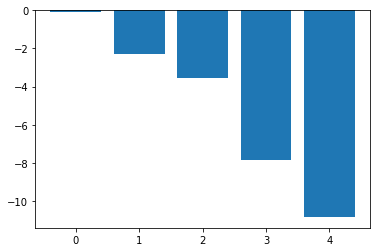

In [38]:
mfd_sellamt_d_1=sp1.LoadDF('mfd_sellamt_d_1').fillna(0)
factorreg(np.array(mfd_sellamt_d_1),rreturns)

4.19613623768
-4.28463068369
-10.9397919972
-3.49757680903
-10.1528378606


[4.1961362376774485,
 -4.2846306836939005,
 -10.939791997216274,
 -3.4975768090316035,
 -10.152837860622805]

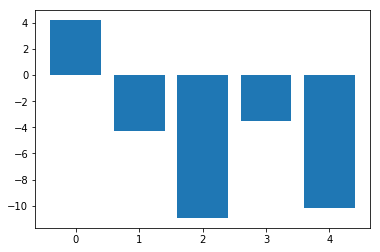

In [39]:
mfd_inflow_m=sp1.LoadDF('mfd_inflow_m').fillna(0)
factorreg(np.array(mfd_inflow_m),rreturns)

-5.66701388177
2.39518962392
-6.29043126092
-6.6324169622
-8.48402863191


[-5.6670138817742588,
 2.3951896239175561,
 -6.290431260923409,
 -6.6324169621950073,
 -8.4840286319119507]

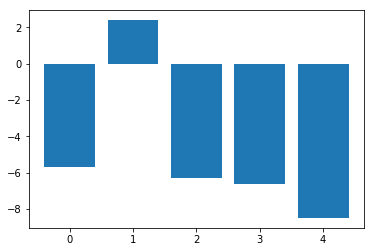

In [40]:
amt=sp1.LoadDF('amt').fillna(0)
factorreg(np.array(amt),rreturns)

11.5701186696
3.00993233189
-9.59851522016
-14.6367397996
-15.0234970946


[11.570118669564948,
 3.0099323318870344,
 -9.5985152201551589,
 -14.636739799633117,
 -15.023497094550974]

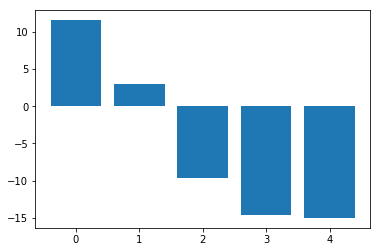

In [41]:
west_eps_FY2=sp1.LoadDF('west_eps_FY2').fillna(0)
factorreg(np.array(west_eps_FY2),rreturns)

10.3750196044
4.4108278078
-9.66729574122
-13.963924026
-15.8333287579


[10.375019604399151,
 4.4108278077956298,
 -9.6672957412153178,
 -13.963924026013476,
 -15.833328757853192]

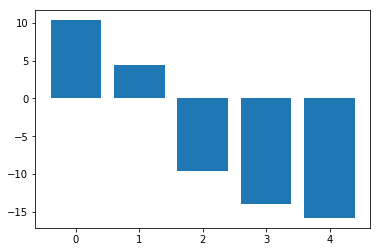

In [42]:
west_eps_FY1=sp1.LoadDF('west_eps_FY1').fillna(0)
factorreg(np.array(west_eps_FY1),rreturns)


                        Sharpe       Return  MaxDrawdown     Turnover
20170104-20171229        2.704        29.12        -4.74          3.6
20180102-20180619       -0.278        -5.22       -12.27         16.4

20170104-20180619        1.326        18.35       -12.27          7.6

                        Sharpe       Return  MaxDrawdown     Turnover
20170104-20171229        1.744        17.24        -5.64          6.5
20180102-20180619       -0.876       -14.87       -11.33         20.4

20170104-20180619        0.570         7.17       -11.33         10.8

                        Sharpe       Return  MaxDrawdown     Turnover
20170104-20171229       -0.139        -1.51       -10.73          5.9
20180102-20180619       -1.597       -28.15       -15.32         19.0

20170104-20180619       -0.738        -9.86       -17.86         10.0

                        Sharpe       Return  MaxDrawdown     Turnover
20170104-20171229       -0.834       -10.62       -15.28          5.9
20180102-2018

[array([[ 1.,  1.,  0., ...,  0.,  1.,  0.],
        [ 1.,  1.,  0., ...,  0.,  1.,  0.],
        [ 1.,  1.,  0., ...,  0.,  1.,  0.],
        ..., 
        [ 1.,  1.,  0., ...,  0.,  0.,  0.],
        [ 1.,  1.,  0., ...,  0.,  0.,  0.],
        [ 1.,  1.,  0., ...,  0.,  0.,  0.]]),
 array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  1.,  0.],
        [ 0.,  0.,  0., ...,  0.,  1.,  0.],
        [ 0.,  0.,  0., ...,  0.,  1.,  0.]]),
 array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([[ 0.,  0.,  0., ...,  1.,  0.,  0.],
        [ 0.,  0.,  0., ...,  1.,  0.,  0.],
        [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       

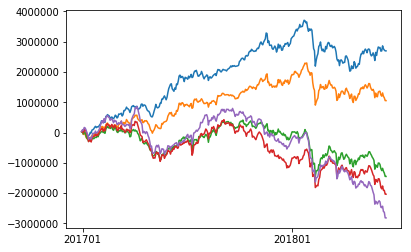

In [49]:
factortestdd(np.array(west_eps_FY1),rreturns)

-2.31862382104
-8.44784489348
-2.0045659766
-12.2574374378
0.349771016


[-2.3186238210410086,
 -8.447844893477118,
 -2.0045659766025503,
 -12.257437437766766,
 0.34977101600029897]

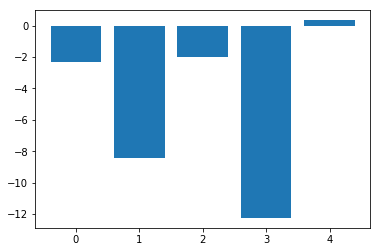

In [43]:
mf_amt=sp1.LoadDF('mf_amt').fillna(0)
factorreg(np.array(mf_amt),rreturns)

-3.29573150967
-3.75392696259
-2.19123451559
-4.01324916293
-11.4245589621


[-3.2957315096668811,
 -3.7539269625874807,
 -2.1912345155870185,
 -4.0132491629328575,
 -11.424558962112938]

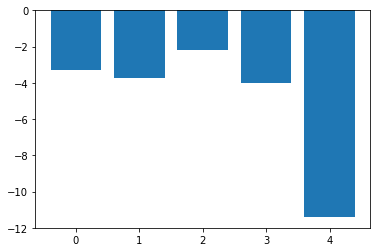

In [44]:
margin_salerepayamount=sp1.LoadDF('margin_salerepayamount').fillna(0)
factorreg(np.array(margin_salerepayamount),rreturns)

-10.6992155335
-0.45398422259
-2.48911593358
-8.6480875259
-2.38829789735


[-10.699215533471241,
 -0.45398422258978005,
 -2.4891159335785669,
 -8.6480875258954555,
 -2.3882978973521092]

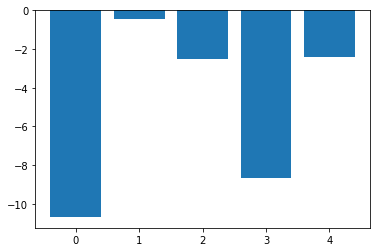

In [45]:
mfd_buyamt_d_4=sp1.LoadDF('mfd_buyamt_d_4').fillna(0)
factorreg(np.array(mfd_buyamt_d_4),rreturns)

-0.803484819919
1.42408654561
-9.27815659989
-8.54809375112
-7.47305248756


[-0.80348481991877874,
 1.4240865456110336,
 -9.2781565998920694,
 -8.5480937511234316,
 -7.4730524875638569]

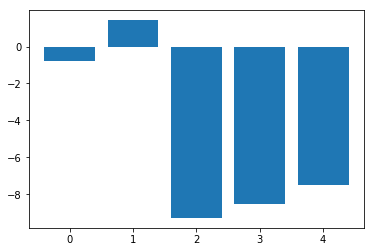

In [46]:
mfd_buyamt_d_2=sp1.LoadDF('mfd_buyamt_d_2').fillna(0)
factorreg(np.array(mfd_buyamt_d_2),rreturns)

-4.23384565489
-1.60073795548
-6.77743966842
-6.66546161203
-5.40121622208


[-4.2338456548900485,
 -1.6007379554783625,
 -6.7774396684173492,
 -6.6654616120262853,
 -5.4012162220751172]

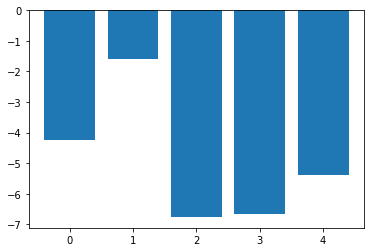

In [47]:
mfd_buyamt_d_3=sp1.LoadDF('mfd_buyamt_d_3').fillna(0)
factorreg(np.array(mfd_buyamt_d_3),rreturns)

2.91868465041
-1.56542499912
-5.51287337572
-10.7384849938
-9.78060239465


[2.9186846504099901,
 -1.5654249991159037,
 -5.512873375718562,
 -10.738484993813314,
 -9.7806023946493639]

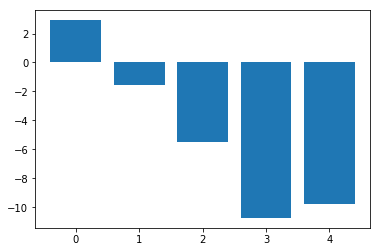

In [48]:
mfd_buyamt_d_1=sp1.LoadDF('mfd_buyamt_d_1').fillna(0)
factorreg(np.array(mfd_buyamt_d_1),rreturns)

-10.4836407355
-4.28708317013
-2.32006527847
4.54352290302
-12.1314348318


[-10.483640735474397,
 -4.2870831701349346,
 -2.3200652784655,
 4.5435229030154307,
 -12.131434831827796]

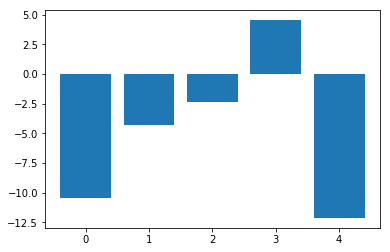

In [50]:
rating_avg=sp1.LoadDF('rating_avg').fillna(0)
factorreg(np.array(rating_avg),rreturns)

1.59115446008
-3.22843238576
-3.49841620991
-6.89820220469
-12.6448047726


[1.5911544600835963,
 -3.2284323857597599,
 -3.4984162099131417,
 -6.8982022046862594,
 -12.644804772611613]

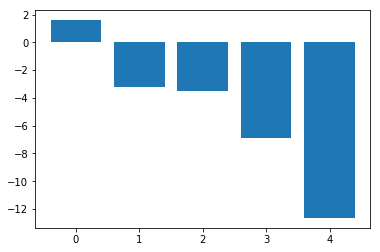

In [51]:
mrg_short_bal=sp1.LoadDF('mrg_short_bal').fillna(0)
factorreg(np.array(mrg_short_bal),rreturns)

-5.00994766801
-4.55940660148
3.96540721846
-3.44325336332
-15.6315006985


[-5.0099476680103514,
 -4.5594066014830448,
 3.9654072184610034,
 -3.4432533633204487,
 -15.631500698534417]

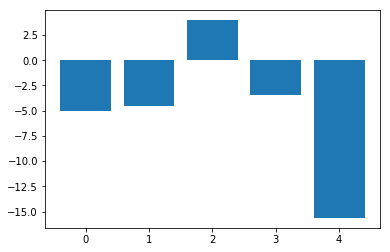

In [52]:
west_netprofit_YOY=sp1.LoadDF('west_netprofit_YOY').fillna(0)
factorreg(np.array(west_netprofit_YOY),rreturns)

0.86772632186
0.0264938320897
-6.28383936773
-12.016602255
-7.27247964408


[0.86772632186023124,
 0.02649383208967783,
 -6.2838393677264257,
 -12.016602255029289,
 -7.2724796440812591]

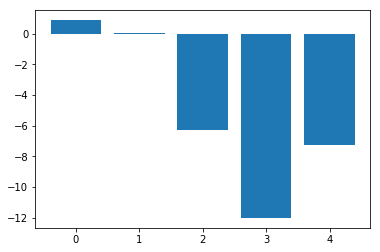

In [54]:
total_shares=sp1.LoadDF('total_shares').fillna(0)
factorreg(np.array(total_shares),rreturns)

6.96043501286
-0.161718604279
0.699531234479
-12.9297878757
-19.2471608802


[6.9604350128601302,
 -0.16171860427901261,
 0.69953123447870014,
 -12.929787875702445,
 -19.247160880244568]

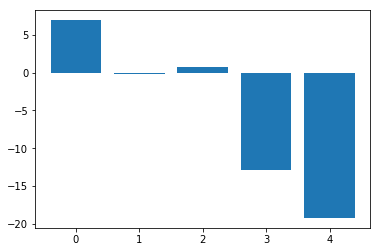

In [55]:
dividendyield2=sp1.LoadDF('dividendyield2').fillna(0)
factorreg(np.array(dividendyield2),rreturns)

13.4105239062
1.88986515046
-5.12818621037
-13.1507540307
-21.7001499285


[13.41052390622789,
 1.8898651504603123,
 -5.1281862103744356,
 -13.150754030672287,
 -21.700149928528678]

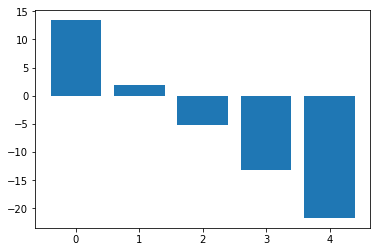

In [56]:
targetprice_avg_wp30=sp1.LoadDF('targetprice_avg_wp30').fillna(0)
factorreg(np.array(targetprice_avg_wp30),rreturns)

-1.51054628194
-7.81693754866
-8.09878365577
-8.14795853695
0.895524910434


[-1.5105462819398496,
 -7.8169375486556518,
 -8.0987836557725359,
 -8.1479585369526699,
 0.89552491043359161]

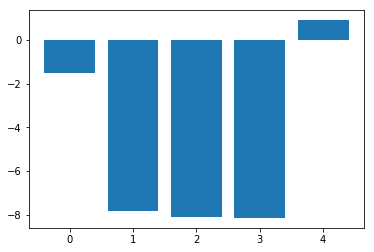

In [57]:
pb_9=sp1.LoadDF('pb_9').fillna(0)
factorreg(np.array(pb_9),rreturns)

-18.9120991525
-1.54271803067
0.0588512263992
-3.11761933859
-1.16511581754


[-18.912099152481762,
 -1.5427180306694428,
 0.058851226399188876,
 -3.1176193385941482,
 -1.1651158175410161]

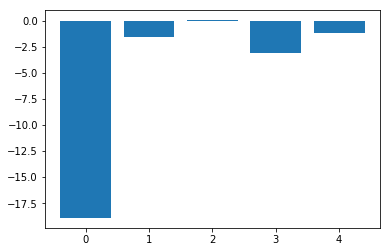

In [58]:
turn=sp1.LoadDF('turn').fillna(0)
factorreg(np.array(turn),rreturns)

8.9448873879
-0.235443493124
-6.40778734904
-14.2074964306
-12.772861228


[8.9448873878978485,
 -0.23544349312425888,
 -6.4077873490409027,
 -14.207496430616603,
 -12.772861228003418]

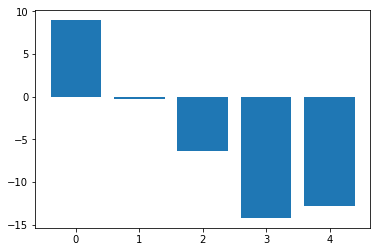

In [59]:
west_avgcps_FY3=sp1.LoadDF('west_avgcps_FY3').fillna(0)
factorreg(np.array(west_avgcps_FY3),rreturns)

11.4984340148
-1.26716226112
-4.15378018629
-12.1434891868
-18.6127034935


[11.498434014809773,
 -1.2671622611154487,
 -4.1537801862852559,
 -12.143489186773374,
 -18.612703493522897]

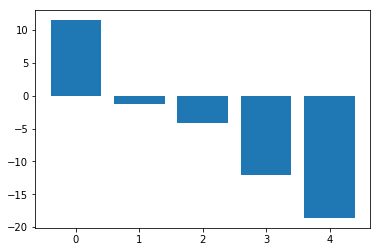

In [60]:
west_avgcps_FY2=sp1.LoadDF('west_avgcps_FY2').fillna(0)
factorreg(np.array(west_avgcps_FY2),rreturns)

8.32937526275
1.81031473992
-8.07375992293
-12.2184942291
-14.5261369635


[8.3293752627463551,
 1.8103147399153194,
 -8.0737599229342134,
 -12.218494229104694,
 -14.526136963509989]

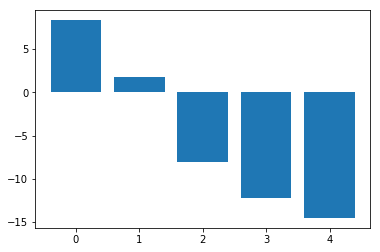

In [61]:
west_avgcps_FY1=sp1.LoadDF('west_avgcps_FY1').fillna(0)
factorreg(np.array(west_avgcps_FY1),rreturns)

-8.17963837558
-5.68310820036
-6.8653224273
0.0316890378327
-3.98232114748


[-8.1796383755806534,
 -5.6831082003576778,
 -6.8653224273023472,
 0.031689037832686548,
 -3.9823211474791398]

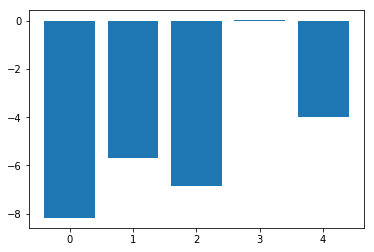

In [62]:
mrg_long_bal=sp1.LoadDF('mrg_long_bal').fillna(0)
factorreg(np.array(mrg_long_bal),rreturns)

-8.53634043636
-2.9974306237
-3.93494130797
-2.153591343
-7.05639740185


[-8.5363404363596942,
 -2.9974306236969674,
 -3.9349413079737481,
 -2.1535913430046603,
 -7.0563974018520605]

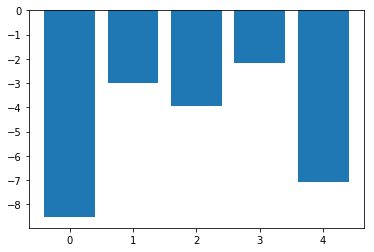

In [63]:
volume=sp1.LoadDF('volume').fillna(0)
factorreg(np.array(volume),rreturns)

-4.84752251443
-1.79018585034
-6.04102065125
-10.4187716821
-1.58120041472


[-4.8475225144324696,
 -1.7901858503418169,
 -6.0410206512537084,
 -10.418771682138324,
 -1.581200414720852]

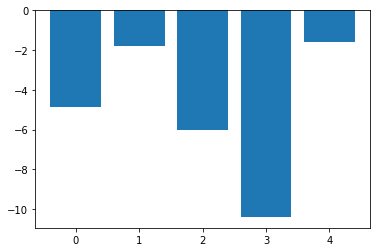

In [65]:
mf_vol=sp1.LoadDF('mf_vol').fillna(0)
factorreg(np.array(mf_vol),rreturns)

11.6221955593
3.41453619985
-5.49922129767
-13.2684996124
-20.947711962


[11.622195559302853,
 3.4145361998509149,
 -5.4992212976715908,
 -13.268499612389412,
 -20.947711961979678]

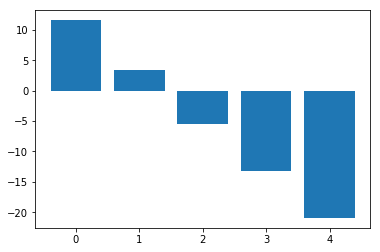

In [67]:
west_netprofit_FTM=sp1.LoadDF('west_netprofit_FTM').fillna(0)
factorreg(np.array(west_netprofit_FTM),rreturns)

-12.761819315
-10.099941927
-3.20240620017
-0.449470452642
1.83493678192


[-12.761819314970086,
 -10.099941927023913,
 -3.2024062001663065,
 -0.44947045264201352,
 1.8349367819150915]

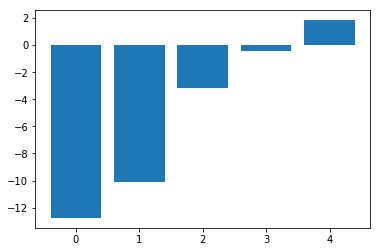

In [69]:
beta_100w=sp1.LoadDF('beta_100w').fillna(0)
factorreg(np.array(beta_100w),rreturns)

-10.4577668477
-1.57169373623
-2.03341673356
-3.01925360758
-7.59657018777


[-10.457766847739292,
 -1.5716937362329091,
 -2.033416733562798,
 -3.0192536075794512,
 -7.5965701877727136]

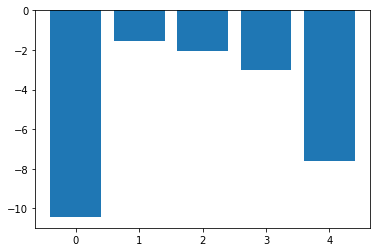

In [70]:
mrg_long_repay=sp1.LoadDF('mrg_long_repay').fillna(0)
factorreg(np.array(mrg_long_repay),rreturns)

-4.34607557976
-0.600083089944
-5.09685191008
-5.66227438163
-8.97341615148


[-4.3460755797615249,
 -0.60008308994389636,
 -5.0968519100767162,
 -5.6622743816284702,
 -8.973416151476524]

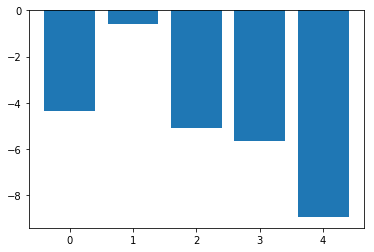

In [71]:
mfd_sellamt_a_2=sp1.LoadDF('mfd_sellamt_a_2').fillna(0)
factorreg(np.array(mfd_sellamt_a_2),rreturns)

-6.24742340573
-0.785059443039
-3.47504740054
-8.40391401751
-5.76725684607


[-6.2474234057311575,
 -0.78505944303859843,
 -3.4750474005403476,
 -8.4039140175118998,
 -5.7672568460651199]

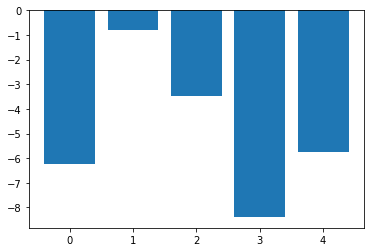

In [72]:
mfd_sellamt_a_3=sp1.LoadDF('mfd_sellamt_a_3').fillna(0)
factorreg(np.array(mfd_sellamt_a_3),rreturns)

-2.04450374401
0.271142481887
-3.21788366612
-5.97880301426
-13.7086531704


[-2.044503744009293,
 0.27114248188660411,
 -3.2178836661232899,
 -5.9788030142587107,
 -13.708653170382517]

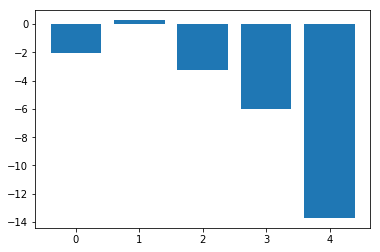

In [73]:
mfd_sellamt_a_1=sp1.LoadDF('mfd_sellamt_a_1').fillna(0)
factorreg(np.array(mfd_sellamt_a_1),rreturns)

-7.44409865182
4.56232578645
-6.65037701432
-6.09570129189
-9.05084994131


[-7.4440986518213981,
 4.5623257864501943,
 -6.650377014318904,
 -6.0957012918871119,
 -9.0508499413099344]

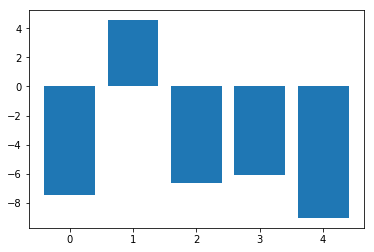

In [74]:
mfd_sellamt_a_4=sp1.LoadDF('mfd_sellamt_a_4').fillna(0)
factorreg(np.array(mfd_sellamt_a_4),rreturns)

10.6863580945
4.09097988019
-10.6539821446
-13.2309427121
-15.5711142309


[10.68635809447156,
 4.0909798801924815,
 -10.653982144566578,
 -13.230942712066341,
 -15.571114230918342]

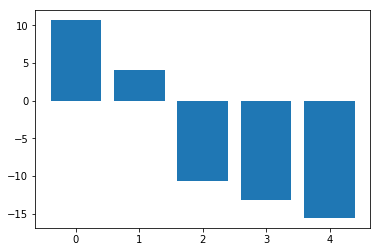

In [75]:
west_eps_FTM=sp1.LoadDF('west_eps_FTM').fillna(0)
factorreg(np.array(west_eps_FTM),rreturns)

-4.99462884691
0.330250057476
-2.28331462017
-4.7727373442
-12.9582703591


[-4.994628846912323,
 0.33025005747638619,
 -2.2833146201717902,
 -4.7727373442026613,
 -12.958270359076799]

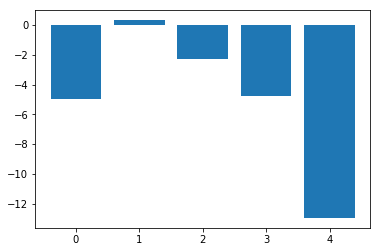

In [76]:
marginornot=sp1.LoadDF('marginornot').fillna(0)
factorreg(np.array(marginornot),rreturns)

-5.46624552025
2.410046212
-1.86848863136
-3.95039249007
-15.8036206832


[-5.4662455202510296,
 2.4100462119980168,
 -1.8684886313556688,
 -3.9503924900684098,
 -15.803620683210097]

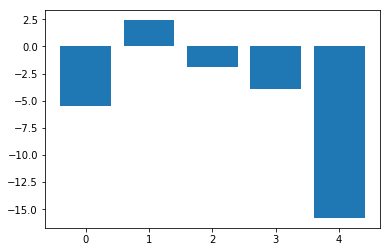

In [77]:
west_sales_YOY=sp1.LoadDF('west_sales_YOY').fillna(0)
factorreg(np.array(west_sales_YOY),rreturns)

-5.27740589283
-0.147926877008
2.46060301985
-2.61281308906
-19.1011582738


[-5.2774058928339205,
 -0.14792687700758425,
 2.4606030198454496,
 -2.6128130890582266,
 -19.101158273832898]

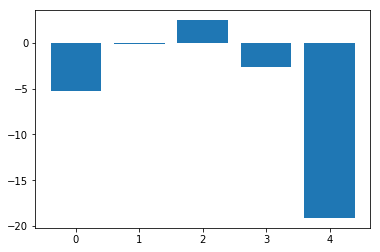

In [78]:
west_netprofit_CAGR=sp1.LoadDF('west_netprofit_CAGR').fillna(0)
factorreg(np.array(west_netprofit_CAGR),rreturns)

-3.51390334513
-0.305410631268
-6.48620450508
-9.11178221502
-5.26140041639


[-3.5139033451329578,
 -0.30541063126817491,
 -6.486204505077791,
 -9.1117822150156815,
 -5.261400416392533]

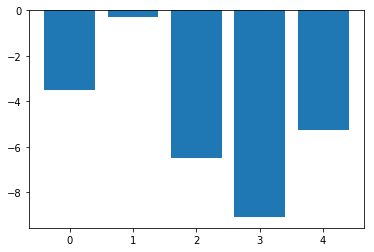

In [79]:
mfd_buyamt_a_3=sp1.LoadDF('mfd_buyamt_a_3').fillna(0)
factorreg(np.array(mfd_buyamt_a_3),rreturns)

-2.05485316856
0.133311200584
-7.01397855336
-9.76175783382
-5.98142275773


[-2.054853168563413,
 0.13331120058405477,
 -7.0139785533583954,
 -9.7617578338165512,
 -5.981422757732858]

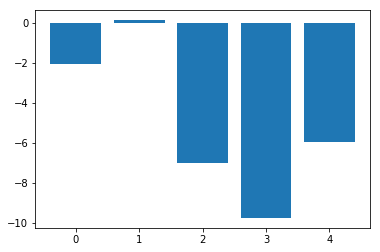

In [80]:
mfd_buyamt_a_2=sp1.LoadDF('mfd_buyamt_a_2').fillna(0)
factorreg(np.array(mfd_buyamt_a_2),rreturns)

0.218220120588
-2.14088490913
-6.64036377331
-10.3907646091
-5.72490794191


[0.21822012058760321,
 -2.1408849091288937,
 -6.6403637733122345,
 -10.390764609119591,
 -5.724907941914041]

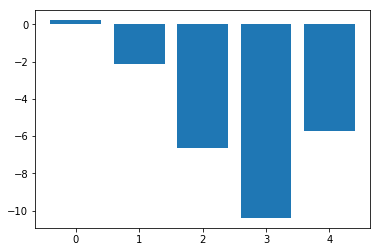

In [81]:
mfd_buyamt_a_1=sp1.LoadDF('mfd_buyamt_a_1').fillna(0)
factorreg(np.array(mfd_buyamt_a_1),rreturns)

9.54901636729
0.724111135037
-5.43669444473
-8.9343648095
-20.580769361


[9.5490163672889086,
 0.72411113503707969,
 -5.4366944447297723,
 -8.9343648095006412,
 -20.580769360982686]

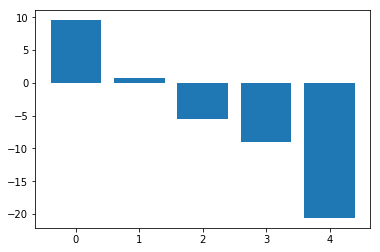

In [82]:
mkt_cap_ashare=sp1.LoadDF('mkt_cap_ashare').fillna(0)
factorreg(np.array(mkt_cap_ashare),rreturns)

-8.01195585399
1.5456435899
-5.56578061883
-10.0483196205
-2.59828860947


[-8.0119558539914255,
 1.5456435898962773,
 -5.5657806188349479,
 -10.048319620482982,
 -2.5982886094740536]

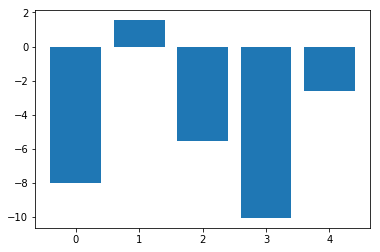

In [83]:
mfd_buyamt_a_4=sp1.LoadDF('mfd_buyamt_a_4').fillna(0)
factorreg(np.array(mfd_buyamt_a_4),rreturns)

2.89888750581
-1.22634069246
-6.51407419327
-9.48307833463
-10.3540953983


[2.8988875058054204,
 -1.2263406924613522,
 -6.5140741932738901,
 -9.4830783346314895,
 -10.354095398325944]

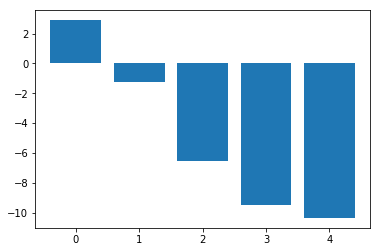

In [84]:
float_a_shares=sp1.LoadDF('float_a_shares').fillna(0)
factorreg(np.array(float_a_shares),rreturns)

7.47362931621
0.984187908341
-3.66232428632
-13.380316508
-16.0938775431


[7.4736293162068401,
 0.98418790834044145,
 -3.6623242863234391,
 -13.380316507995865,
 -16.093877543115138]

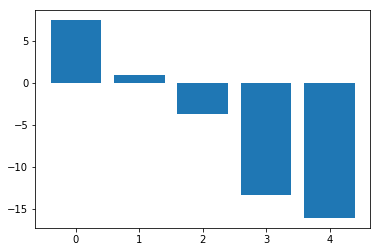

In [85]:
mkt_cap_ashare2=sp1.LoadDF('mkt_cap_ashare2').fillna(0)
factorreg(np.array(mkt_cap_ashare2),rreturns)